In [27]:
#!/usr/bin/env python3
"""
Train a linear two-layer FCN (standard scaling) and compare its outputs with GPR (linear kernel).
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import scipy.stats as stats
import matplotlib.pyplot as plt
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')

# FCNX-Ensembling/journal/test_linear_fcn2.ipynb

import torch
import numpy as np
import pytest

from FCN2Network import FCN2NetworkEnsembleLinear

seed = 42
# Config
d = 10
P = 50
N = 1028
ens = 10
epochs = 80000
lr = 1e-5
T = 0.02
weight_var = (1.0/d, 1.0/N)
device = torch.device("cuda:1")

torch.manual_seed(seed)
np.random.seed(seed)

# Data
X = torch.randn(P, d, device=device)
Y = X[:, 0].unsqueeze(1)

# Model
model = FCN2NetworkEnsembleLinear(
    d=d, n1=N, P=P, ens=ens,
    weight_initialization_variance=weight_var,
    device=device
)

# Langevin training loop
for epoch in range(epochs):
    model.zero_grad()
    out = model(X)  # (P, ens)
    loss = ((out-Y) ** 2).sum()
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            # Weight decay: 0 for linear kernel test (matches GPR)
            # Langevin noise
            noise = torch.randn_like(p) * (2 * lr * T) ** 0.5
            p.add_(p.grad, alpha=-lr)
            p.add_(noise)
        if epoch % 5000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# GPR prediction (linear kernel)
def linear_kernel(X1, X2):
    return (X1 @ X2.T) / d

def gpr_predict(X_train, Y_train, X_test, sigma0_sq=0.01):
    K_xx = linear_kernel(X_train, X_train) + sigma0_sq * torch.eye(X_train.shape[0], device=device)
    K_xstar_x = linear_kernel(X_test, X_train)
    alpha = torch.linalg.solve(K_xx, Y_train)
    return K_xstar_x @ alpha

with torch.no_grad():
    model_out = model(X).mean(dim=1).cpu().numpy()
    gpr_out = gpr_predict(X, Y, X).cpu().numpy().squeeze()



Epoch 0, Loss: 859.8522
Epoch 5000, Loss: 1.0840
Epoch 10000, Loss: 0.9960
Epoch 15000, Loss: 1.2124
Epoch 20000, Loss: 1.1292
Epoch 25000, Loss: 1.1011
Epoch 30000, Loss: 1.1733
Epoch 35000, Loss: 0.6729
Epoch 40000, Loss: 1.1327
Epoch 45000, Loss: 1.3465
Epoch 50000, Loss: 0.8297
Epoch 55000, Loss: 1.2241
Epoch 60000, Loss: 1.0066
Epoch 65000, Loss: 1.2651
Epoch 70000, Loss: 1.2128
Epoch 75000, Loss: 1.2374


In [31]:
model_out_ensemble_stderr

array([0.01557793, 0.01392731, 0.0178711 , 0.01612171, 0.00904059,
       0.00784221, 0.01491305, 0.01380816, 0.01010277, 0.01221889,
       0.01500719, 0.01126857, 0.00517468, 0.01676997, 0.01284573,
       0.01718001, 0.009292  , 0.00716143, 0.01414332, 0.01061649,
       0.00869714, 0.00924167, 0.01298289, 0.00827512, 0.01225471,
       0.01160663, 0.00817844, 0.00811909, 0.0128335 , 0.01304108,
       0.01629975, 0.02256652, 0.02494159, 0.02082142, 0.01530356,
       0.01778912, 0.01191782, 0.01226876, 0.00951881, 0.01336556,
       0.00544902, 0.01299531, 0.01452036, 0.01230074, 0.0126585 ,
       0.01154378, 0.00962926, 0.01005392, 0.00925453, 0.01274966])

<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\k'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_2931024/4274122332.py:10: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar(gpr_out, model_out, yerr=model_out_ensemble_stderr, fmt='o', alpha=0.5, label='FCN2 f(x) $\pm \sigma/\sqrt{10}$')
/tmp/ipykernel_2931024/4274122332.py:13: SyntaxWarning: invalid escape sequence '\k'
  plt.title(f"FCN2 vs GPR ($\kappa = 0.01, d = 10, N = 1028, P = 50$): Correlation coefficient={corr:.4f}, MSE={sse:.4f}")


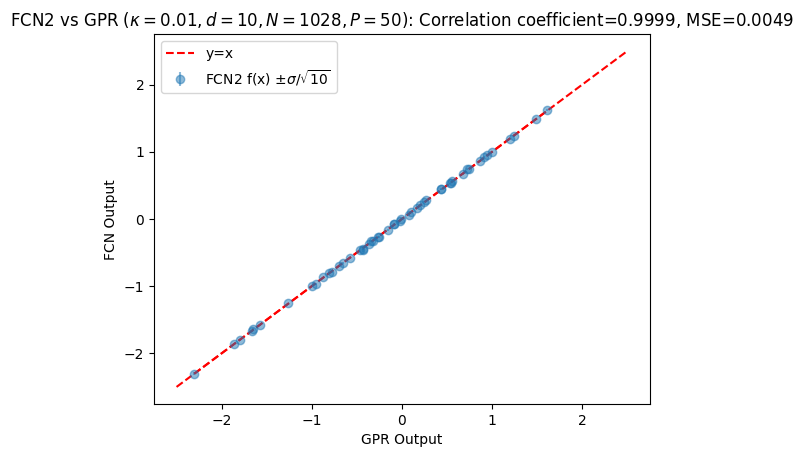

In [30]:

import matplotlib.pyplot as plt
# Plot model results vs GPR

corr = np.corrcoef(model_out, gpr_out)[0, 1]
sse = np.sum((model_out - gpr_out) ** 2)

# The model should match GPR closely
assert corr > 0.98, f"Correlation too low: {corr}"
model_out_ensemble_stderr = np.std(model(X).detach().cpu().numpy(), axis=1) / np.sqrt(ens)
plt.errorbar(gpr_out, model_out, yerr=model_out_ensemble_stderr, fmt='o', alpha=0.5, label='FCN2 f(x) $\pm \sigma/\sqrt{10}$')
plt.xlabel("GPR Output")
plt.ylabel("FCN Output")
plt.title(f"FCN2 vs GPR ($\kappa = 0.01, d = 10, N = 1028, P = 50$): Correlation coefficient={corr:.4f}, MSE={sse:.4f}")
plt.plot([gpr_out.min(), gpr_out.max()], [gpr_out.min(), gpr_out.max()], 'r--', label='y=x')
# Plotting the identity line
plt.plot([-2.5, 2.5], [-2.5, 2.5], 'r--')
plt.legend()
plt.show()

Network 1: corr=0.9577, mse=1.2206e-01
Network 2: corr=0.8786, mse=1.6771e-01
Network 3: corr=0.9589, mse=9.8278e-02
Network 4: corr=0.9198, mse=1.4515e-01
Network 5: corr=0.9423, mse=1.1581e-01


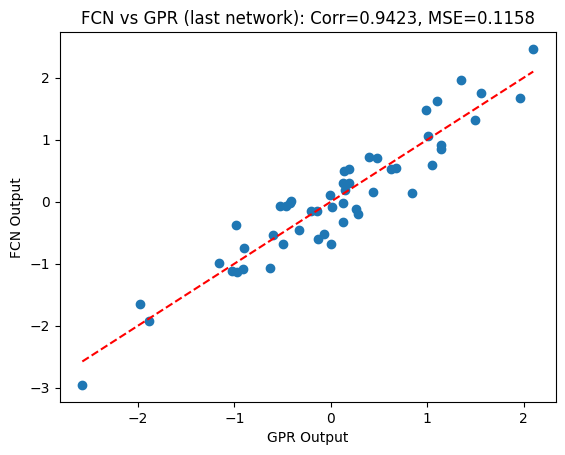

In [32]:
num_networks = 5
results = []

for net_idx in range(num_networks):
    # New dataset for each network
    X = torch.randn(P, d, device=device)
    Y = X[:, 0].unsqueeze(1)

    # New model for each dataset
    model = FCN2NetworkEnsembleLinear(
        d=d, n1=N, P=P, ens=ens,
        weight_initialization_variance=weight_var,
        device=device
    )

    # Langevin training loop
    for epoch in range(epochs):
        model.zero_grad()
        out = model(X)  # (P, ens)
        loss = ((out.mean(dim=1, keepdim=True) - Y) ** 2).mean()
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                noise = torch.randn_like(p) * (2 * lr * T) ** 0.5
                p.add_(p.grad, alpha=-lr)
                p.add_(noise)

    # GPR prediction (linear kernel)
    def linear_kernel(X1, X2):
        return (X1 @ X2.T) / d

    def gpr_predict(X_train, Y_train, X_test, sigma0_sq=1e-6):
        K_xx = linear_kernel(X_train, X_train) + sigma0_sq * torch.eye(X_train.shape[0], device=device)
        K_xstar_x = linear_kernel(X_test, X_train)
        alpha = torch.linalg.solve(K_xx, Y_train)
        return K_xstar_x @ alpha

    with torch.no_grad():
        model_out = model(X).mean(dim=1).cpu().numpy()
        gpr_out = gpr_predict(X, Y, X).cpu().numpy().squeeze()

    corr = np.corrcoef(model_out, gpr_out)[0, 1]
    mse = np.mean((model_out - gpr_out) ** 2)
    results.append((corr, mse))
    print(f"Network {net_idx+1}: corr={corr:.4f}, mse={mse:.4e}")

# Optionally, plot the last network's results
plt.scatter(gpr_out, model_out)
plt.xlabel("GPR Output")
plt.ylabel("FCN Output")
plt.title(f"FCN vs GPR (last network): Corr={corr:.4f}, MSE={mse:.4f}")
plt.plot([gpr_out.min(), gpr_out.max()], [gpr_out.min(), gpr_out.max()], 'r--')
plt.show()